# Fitting Gaussian Profiles

In [3]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import ugradio

### A Quick Aside: Radiometer Equation

The radiometer equation relates the noise/uncertainty on a measurement to the total power (or temperature) entering the system.

\begin{equation}
T_{\rm rms} = \frac{T_{\rm sys}}{\sqrt{2 B t}}
\end{equation}

In [4]:
SIZE = 10000
TSYS = 1
noise = TSYS * np.random.normal(size=SIZE)
#print(np.mean(noise))
#print(np.mean(noise**2))
#print(np.std(noise**2))

In [5]:
def gen_mock_profile(freqs, amp, avg, sig, noise_lev=1):
    signal = ugradio.gauss.gaussval(freqs, amp=amp, avg=avg, sig=sig)
    #signal = 0
    #for T, nu0, sig in zip(Ts, nu0s, sigmas):
    #    signal += T * np.exp(-(nu0 - freqs)**2 / (2 * sig**2))
    return signal + noise_lev * np.random.normal(size=freqs.shape)

<IPython.core.display.Javascript object>


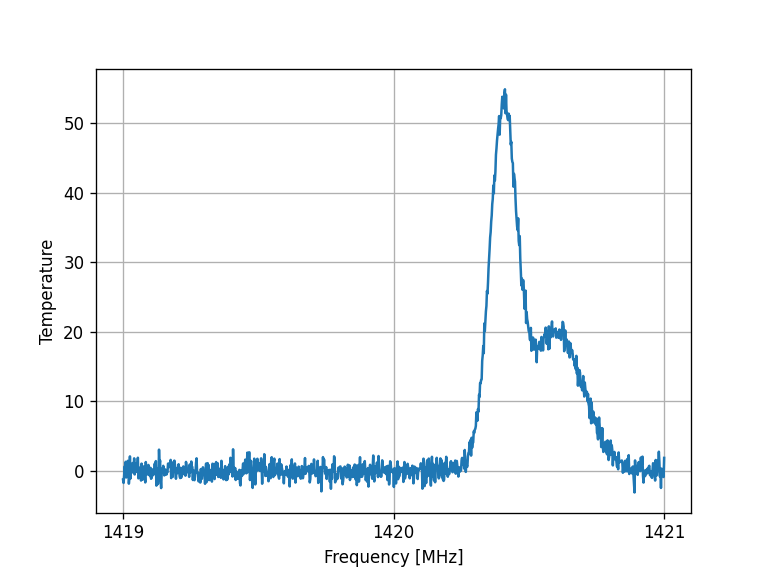

In [6]:
NCHAN = 1024
TSYS = 1
freqs = np.linspace(1419e6, 1421e6, NCHAN)
prms_true = {
    'amp': np.array([50, 20]),
    'avg': np.array([1420.405e6, 1420.6e6]),
    'sig': np.array([0.05e6, 0.1e6])
}
T21 = gen_mock_profile(freqs, noise_lev=TSYS, **prms_true)
plt.figure()
plt.plot(freqs/1e6, T21)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature')
plt.xticks([1419, 1420, 1421])
_ = plt.grid()

## Method 1: Gaussfit using (under the hood) scipy.curvefit

In [7]:
ans1 = ugradio.gauss.gaussfit(freqs, T21, amp=20, avg=1420.5e6, sig=1e6)
profile1 = ugradio.gauss.gaussval(freqs, **ans1)

<IPython.core.display.Javascript object>


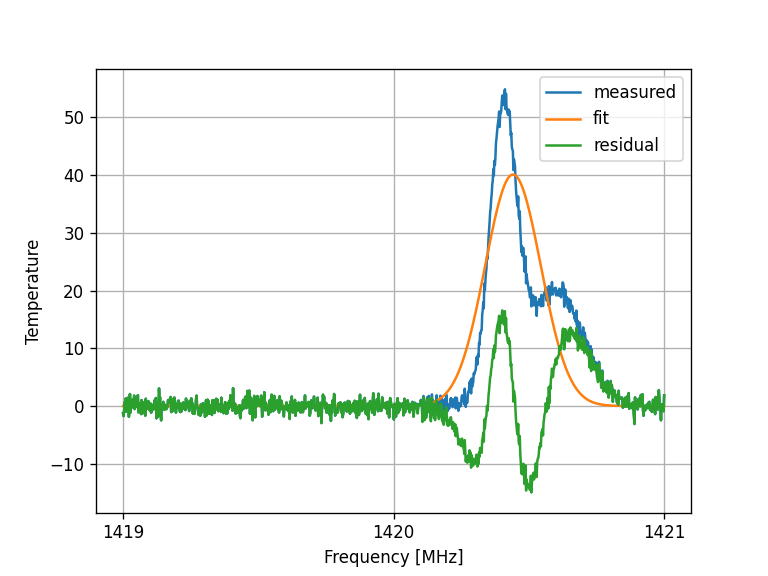

In [8]:
plt.figure()
plt.plot(freqs/1e6, T21, label='measured')
plt.plot(freqs/1e6, profile1, label='fit')
plt.plot(freqs/1e6, T21 - profile1, label='residual')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature')
plt.xticks([1419, 1420, 1421])
plt.legend()
_ = plt.grid()

In [9]:
chisq = np.sum(np.abs(T21 - profile1)**2 / TSYS**2)
print(f'Chi-Square: {chisq}')

Chi-Square: 25755.757775166974


In [10]:
chisq_r = np.sum(np.abs(T21 - profile1)**2 / TSYS**2) / (freqs.size - 3)
print(f'Reduced Chi-Square: {chisq_r}')

Reduced Chi-Square: 25.22601153297451


In [11]:
ans2 = ugradio.gauss.gaussfit(freqs, T21, amp=[20,20], avg=[1420.4e6,1420.6e6], sig=[1e5,1e5])
profile2 = ugradio.gauss.gaussval(freqs, **ans2)

In [12]:
chisq = np.sum(np.abs(T21 - profile2)**2)
print(f'Chi-Square: {chisq}')
chisq_r = np.sum(np.abs(T21 - profile2)**2 / TSYS**2) / (freqs.size - 6)
print(f'Reduced Chi-Square: {chisq_r}')

Chi-Square: 939.348677607904
Reduced Chi-Square: 0.9227393689665069


<IPython.core.display.Javascript object>


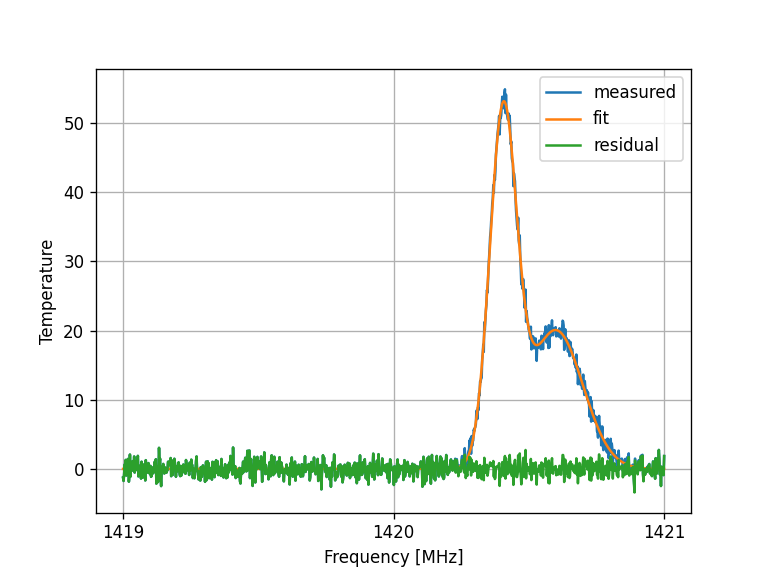

In [13]:
plt.figure()
plt.plot(freqs/1e6, T21, label='measured')
plt.plot(freqs/1e6, profile2, label='fit')
plt.plot(freqs/1e6, T21 - profile2, label='residual')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Temperature')
plt.xticks([1419, 1420, 1421])
plt.legend()
_ = plt.grid()

In [14]:
print(ans2)

{'amp': array([50.01391966, 20.04884266]), 'avg': array([1.42040460e+09, 1.42059918e+09]), 'sig': array([ 49774.29273642, 100173.41838488])}


In [15]:
amp0, amp1 = ans2['amp'].copy()
#amp0, amp1 = prms_true['amp'].copy()
amp0s = np.linspace(0.95*amp0, 1.05*amp0, 200)
chisq = []
for amp0_test in amp0s:
    prms = {k: v.copy() for k, v in ans2.items()}
    #prms = {k: v.copy() for k, v in prms_true.items()}
    prms['amp'] = np.array([amp0_test, amp1])
    _profile = ugradio.gauss.gaussval(freqs, **prms)
    chisq.append(np.sum(np.abs(T21 - _profile)**2/TSYS**2))

amp = 50.013919659368895 +/- 0.28902516386067134


<IPython.core.display.Javascript object>


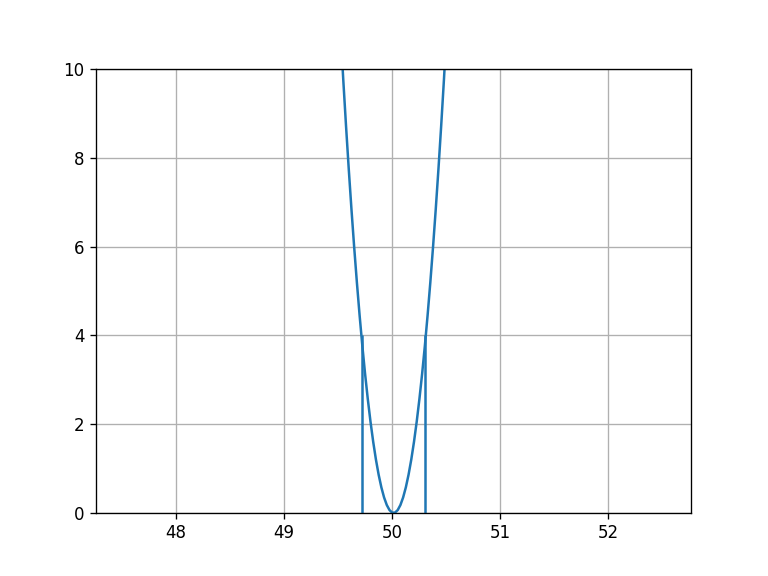

In [84]:
chisq_norm = np.array(chisq).copy()
chisq_norm -= chisq_norm.min()
inds = np.argwhere(chisq_norm < 2**2)
amp_min, amp_max = amp0s[inds[0]], amp0s[inds[-1]]
print(f'amp = {amp0} +/- {(amp_max[0] - amp_min[0])/2}')
plt.figure()
plt.plot(amp0s, chisq_norm)
plt.vlines([amp_min, amp_max], ymin=0, ymax=4)
plt.ylim(0, 10)
_ = plt.grid()

## Markov Chain Monte Carlo (Using PyMC)

In [19]:
import pymc3 as pm
import theano
import theano.tensor as tt

In [74]:
model = pm.Model()

def gauss(x, amp, center, width):
    return amp * np.exp(-(x - center)**2 / (2 * width**2))

def log_likelihood(y, yhat, sig_noise):
    L = -0.5*(np.log(2 * np.pi * sig_noise**2) + (y - yhat)**2 / sig_noise**2 )
    return tt.sum(L)

with model:
    amp1 = pm.Uniform('amp1', lower=30, upper=70)
    cen1 = pm.Uniform('cen1', lower=1420e6, upper=1420.5e6) # separated from 2 below
    wid1 = pm.Uniform('wid1', lower=0.01e6, upper=0.3e6)
    amp2 = pm.Uniform('amp2', lower=1, upper=30)
    cen2 = pm.Uniform('cen2', lower=1420.5e6, upper=1421e6) # separated from 1 above
    wid2 = pm.Uniform('wid2', lower=0.01e6, upper=0.3e6)
    yhat = gauss(freqs, amp1, cen1, wid1) + gauss(freqs, amp2, cen2, wid2)
    sig_noise = theano.shared(TSYS)
    
    pm.Potential("loglike", log_likelihood(y=theano.shared(T21), yhat=yhat, sig_noise=sig_noise))

with model:
    trace = pm.sample(2500)

/home/aparsons/.local/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [wid2, cen2, amp2, wid1, cen1, amp1]
INFO:pymc3:NUTS: [wid2, cen2, amp2, wid1, cen1, amp1]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 8 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 8 seconds.


<IPython.core.display.Javascript object>


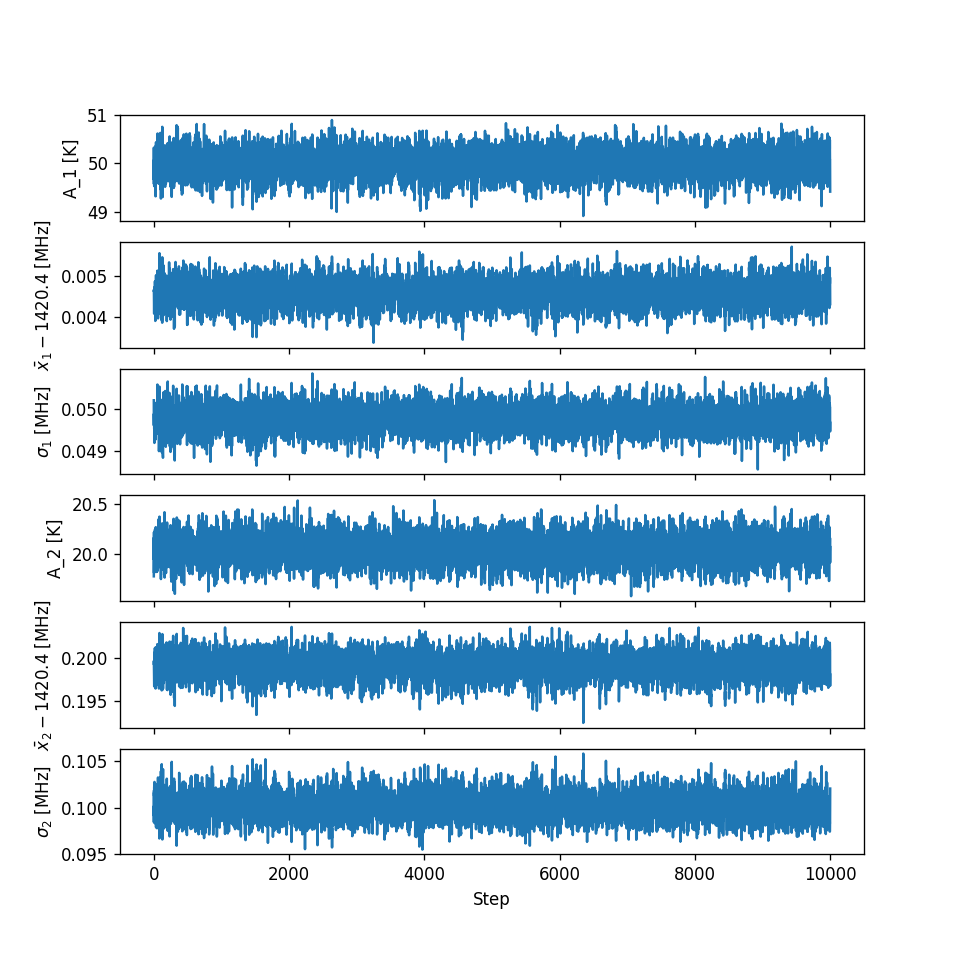

Text(0.5, 0, 'Step')

In [82]:
fig, axes = plt.subplots(nrows=6, sharex=True, figsize=(8,8))
axes[0].plot(trace['amp1'])
axes[0].set_ylabel('A_1 [K]')
axes[1].plot(trace['cen1'] / 1e6 - 1420.4)
axes[1].set_ylabel('$\\bar x_1 - 1420.4$ [MHz]')
axes[2].plot(trace['wid1'] / 1e6)
axes[2].set_ylabel('$\\sigma_1$ [MHz]')
axes[3].plot(trace['amp2'])
axes[3].set_ylabel('A_2 [K]')
axes[4].plot(trace['cen2'] / 1e6 - 1420.4)
axes[4].set_ylabel('$\\bar x_2 - 1420.4$ [MHz]')
axes[5].plot(trace['wid2'] / 1e6)
axes[5].set_ylabel('$\\sigma_2$ [MHz]')
axes[5].set_xlabel('Step')

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


<IPython.core.display.Javascript object>


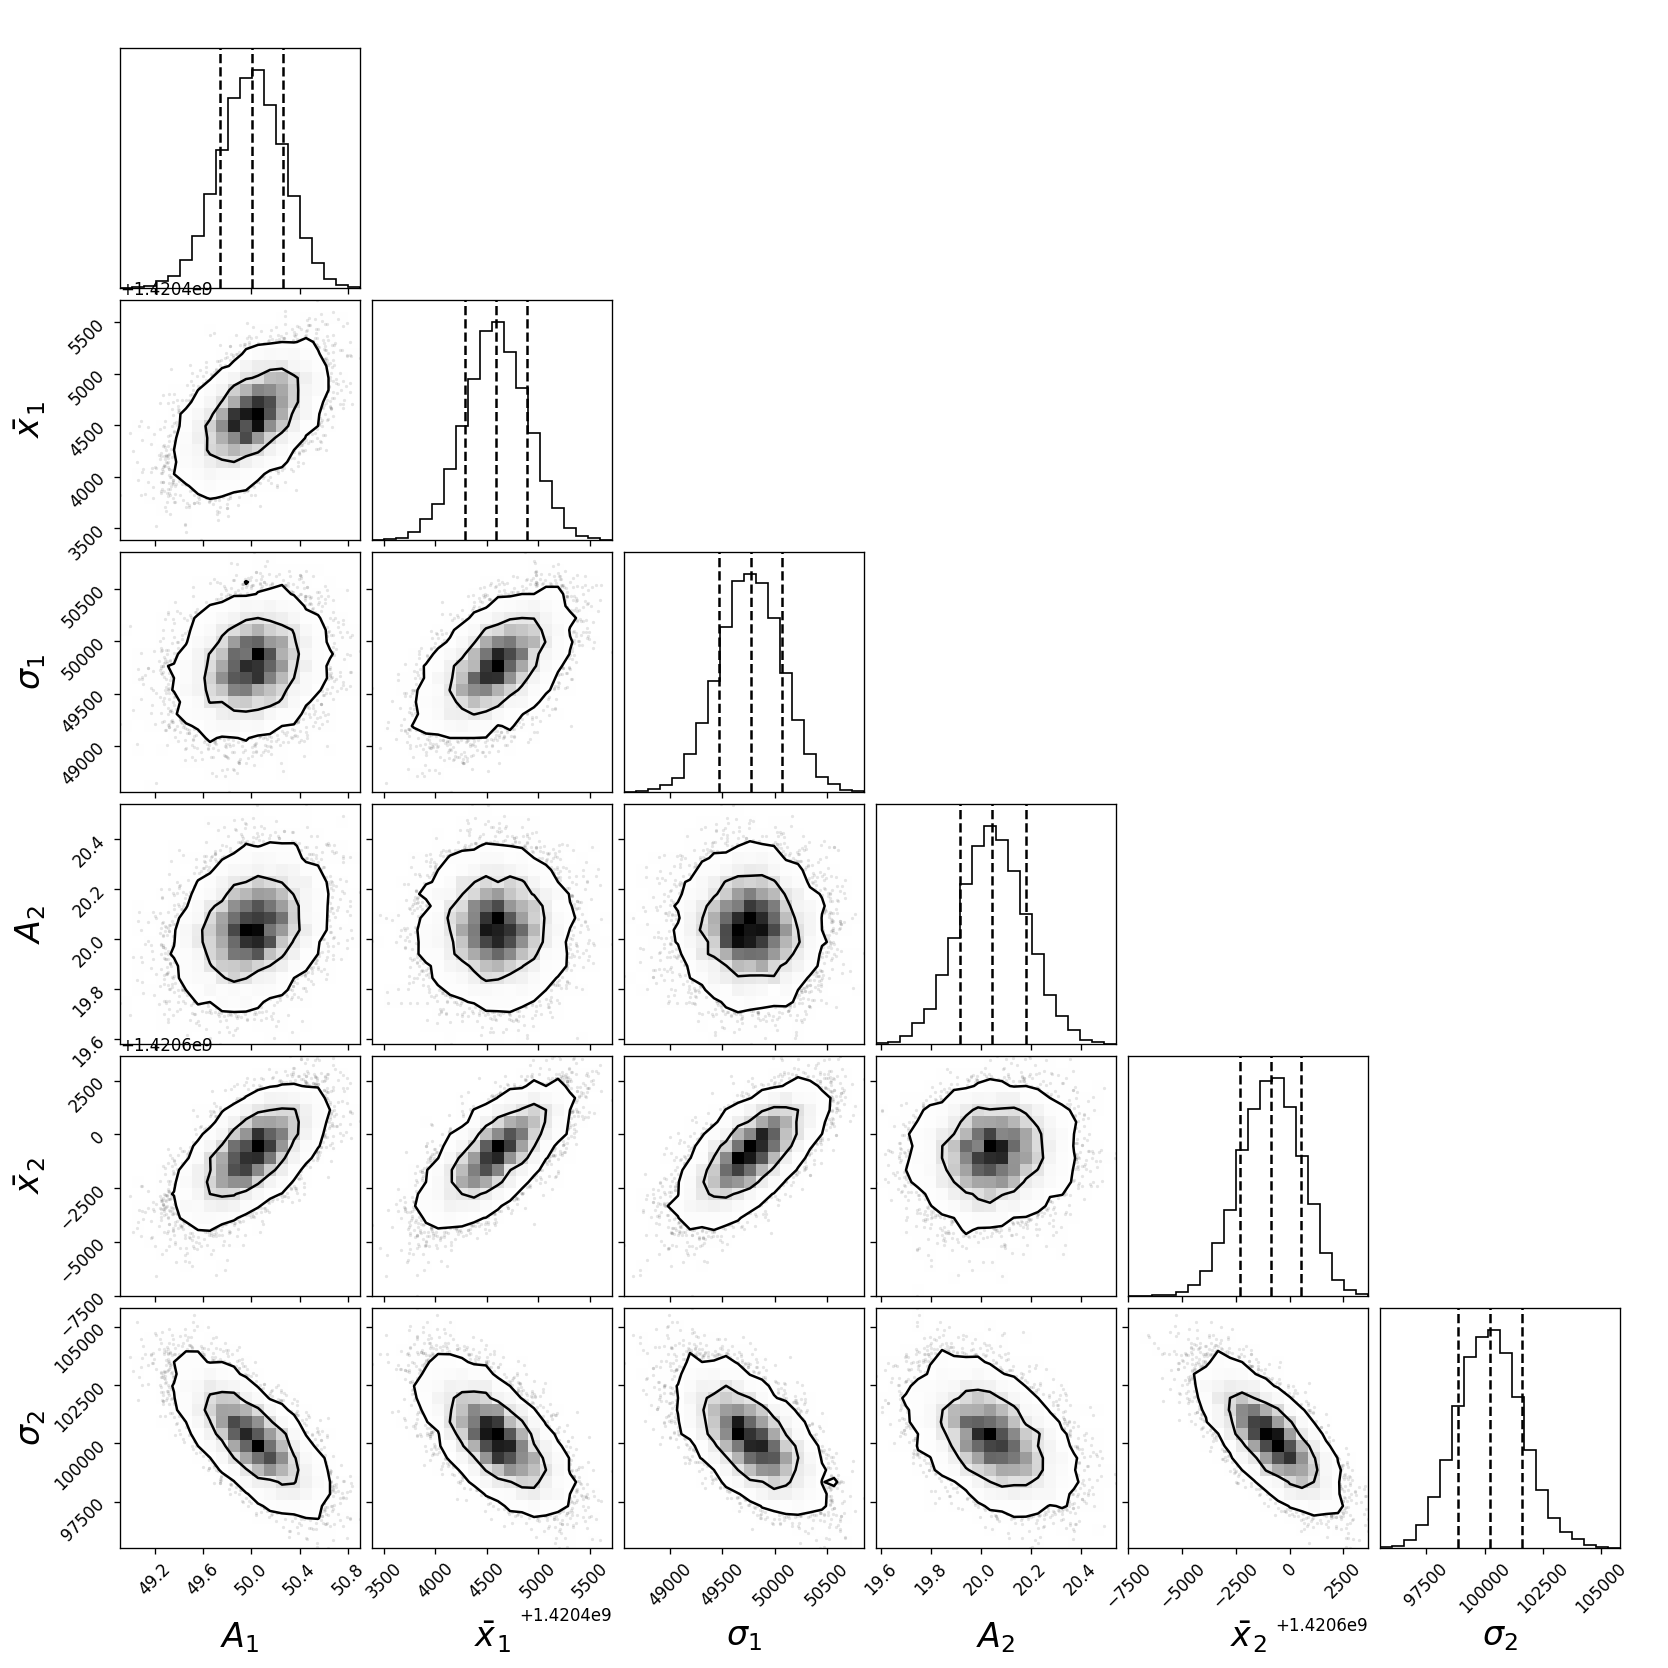

In [80]:
import corner

fig = corner.corner(trace, 
        labels = [r'$A_1$', r'$\bar x_1$', r'$\sigma_1$', r'$A_2$', r'$\bar x_2$', r'$\sigma_2$'],
        levels=(0.68, 0.95,),
        label_kwargs={"fontsize": 20}, quantiles=[0.159, 0.5, 0.841])

In [78]:
print(f"amp1 = {np.mean(trace['amp1'])} +/- {np.std(trace['amp1'])}")
print(f"cen1 = {np.mean(trace['cen1']) / 1e6} +/- {np.std(trace['cen1']) / 1e6}")
print(f"wid1 = {np.mean(trace['wid1']) / 1e6} +/- {np.std(trace['wid1']) / 1e6}")
print(f"amp2 = {np.mean(trace['amp2'])} +/- {np.std(trace['amp2'])}")
print(f"cen2 = {np.mean(trace['cen2']) / 1e6} +/- {np.std(trace['cen2']) / 1e6}")
print(f"wid2 = {np.mean(trace['wid2']) / 1e6} +/- {np.std(trace['wid2']) / 1e6}")

amp1 = 49.9988585104848 +/- 0.26396698727754137
cen1 = 1420.4045913016275 +/- 0.0003030824478067803
wid1 = 0.0497686656167476 +/- 0.00029968876990526557
amp2 = 20.048355153351306 +/- 0.13425505473335453
cen2 = 1420.599120076572 +/- 0.0014127648019629257
wid2 = 0.10023185049008897 +/- 0.0013815585386991345


In [ ]:
# Remember the true answers:
# 'amp': np.array([50, 20]),
# 'avg': np.array([1420.405e6, 1420.6e6]),
# 'sig': np.array([0.05e6, 0.1e6])